In [107]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle


In [129]:

# define the path to the input images
input_path = r"C:\Users\user\Documents\GitHub\Hand Gesture\Hand-Gesture\input"

# define the path to the output preprocessed images
output_path = r"C:\Users\user\Documents\GitHub\Hand Gesture\Hand-Gesture\output"

# define the target size of the preprocessed images
target_size = (64, 64)

# define the preprocessing functions


def convert_to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    return gray


def apply_gaussian_blur(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    return blurred


def apply_threshold(img):
    _, thresh = cv2.threshold(
        img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh


def find_contours(img):
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy


def find_largest_contour(contours):
    max_contour = max(contours, key=cv2.contourArea)
    return max_contour


def create_mask(img, contour):
    mask = cv2.drawContours(np.zeros_like(
        img), [contour], 0, (255, 255, 255), -1)
    return mask


def apply_mask(img, mask):
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    return masked_image


def resize_image(img, size):
    resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return resized


def normalize_image(img):
    normalized = img.astype("float32") / 255.0
    return normalized


def get_hog_features(img):
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size,
                            block_stride, cell_size, nbins)
    hog_feats = hog.compute(img)
    return hog_feats


def get_sift_features(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return descriptors

def split_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def svm_model(X_train, y_train, X_test):
    clf = svm.SVC(kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
   
    # filename = 'SVC.sav'
    # pickle.dump(clf, open(filename, 'wb'))
    
    return y_pred



def calc_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [98]:
#preprocessing phase        
def preprocess(img_path):
    img = io.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = apply_gaussian_blur(gray)
    blurred = np.uint8(blurred)
    thresh = apply_threshold(blurred)
    contours, hierarchy = find_contours(thresh)
    max_contour = find_largest_contour(contours)
    mask = create_mask(gray, max_contour)
    masked_image = apply_mask(img, mask)
    resized = resize_image(masked_image, target_size)
    normalized = normalize_image(resized)
    
    return normalized

def preprocess_2(img_path):
    img = io.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray)
    
    processed = equ
    
    if processed.shape[2] == 3:
       processed = processed[0] 
    return processed

def preprocess_3(img_path):
    img = io.imread(img_path)

    #1 Image Rescaling
    img = cv2.resize(img, (320, 180))

    #2 Image Enhancement
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)

    #3 Background Subtraction
    fgbg = cv2.createBackgroundSubtractorMOG2()
    fgmask = fgbg.apply(img_gray)
    img_gray = cv2.bitwise_and(img_gray, img_gray, mask=fgmask)

    #4 Skin Color Detection
    # lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    # upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    # hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # mask = cv2.inRange(hsv_img, lower_skin, upper_skin)
    # img_gray = cv2.bitwise_and(img_gray, img_gray, mask=mask)

    # #5 Noise Reduction
    img_gray = cv2.medianBlur(img_gray, 3)

    # #6 Image Segmentation
    # ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # img_gray = cv2.bitwise_and(img_gray, img_gray, mask=thresh)
    
    return img_gray

# preprocessed = preprocess_3('dataset/5/5_men (26).jpg')
# cv2.imshow('Processed Image', preprocessed)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [60]:
# set the parameters for HoG
orientations = 9
pixels_per_cell = (50, 50)
cells_per_block = (3, 3)
visualize = False
transform_sqrt = False
normalize = True
load_features_from_file=False
save_feature=True
all_feats = []
all_imgs = []

image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

if load_features_from_file == False:
    for root, dirs, files in os.walk('dataset'):
        for dir in dirs:
            i = 0
            print(os.path.join(root, dir))
            for file in os.listdir(os.path.join(root, dir)):
                i+=1
                if any(file.lower().endswith(extension) for extension in image_extensions):
                    img_path = os.path.join(root, dir, file)
                    print(i)
                    # print(img_path)
                    label = np.array([int(dir)])
                    
                    processed = preprocess_3(img_path)
                    # processed = io.imread(img_path, as_gray=True)
                    # print(processed.shape)

                    #calculate the HoG features for the image
                    hog_result = hog(
                        processed,
                        orientations = orientations,
                        pixels_per_cell = pixels_per_cell,
                        cells_per_block = cells_per_block,
                        visualize = visualize,
                        transform_sqrt = transform_sqrt,
                        block_norm = 'L2-Hys',
                        feature_vector = True
                    )

                    # unpack the HoG result into features and hog_image variables if necessary
                    if visualize:
                        features, hog_image = hog_result
                    else:
                        features = hog_result
                    
                    feats = np.concatenate((label, features.ravel()))
                    all_feats.append(feats)
           
else:
    all_feats = np.loadtxt("hog_features.txt")

features_array = np.array(all_feats, dtype=object)

if(save_feature):
    np.savetxt("hog_features.txt", features_array)


print("Feature Extraction Finished")

dataset\0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

In [61]:
print(features_array.shape)

(1821, 325)


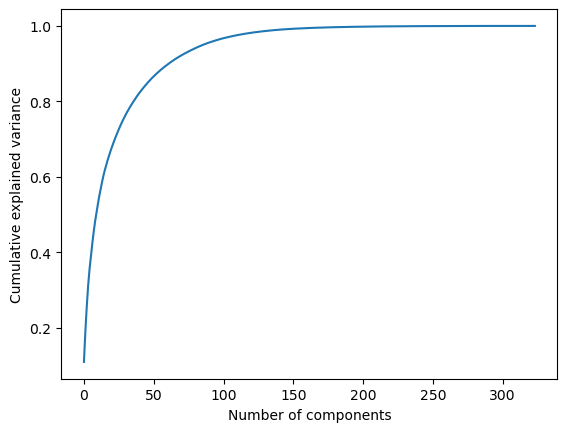

In [126]:
# get the optimal number of components to use

pca = PCA().fit(features_array[:, 1:])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [127]:
features_array = np.array(all_feats, dtype=object)

In [130]:
# apply PCA
pca = PCA(n_components=100)
Y = np.array(features_array[:, 0]).astype('int32')
X = pca.fit_transform(features_array[:, 1:])


# splitting data into train and test
X_train, X_test, y_train, y_test = split_dataset(X, Y)

print(X_train.shape)
print(y_train.shape)

# apply SVM
y_pred = svm_model(X_train, y_train, X_test)


print("SVM Finished")

(1456, 100)
(1456,)
SVM Finished


In [131]:
# calc accuracy
accuracy = calc_accuracy(y_test, y_pred)
print(accuracy)

0.7534246575342466
